In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import yfinance as yf
import ta
from sklearn.decomposition import PCA
from neurodsp import sim #for brownian motion 
from math import log, floor

## Pipeline

* Get tickers and their sectors (Prob need a better more up to date way of getting tickers)
* Compare PCA and SSA for finding similar patterns
    - Maybe do this on some sort of moving averages (how to figure out time windows?)
* Cluster

### Also
- DFA, brownian motion modelling

In [2]:
tickers = pd.read_csv('data/historical_stocks.csv')
tickers = tickers.dropna(axis=0, how='any')

In [3]:
tickers.head()

,ticker,exchange,name,sector,industry
0,PIH,NASDAQ,"1347 PROPERTY INSURANCE HOLDINGS, INC.",FINANCE,PROPERTY-CASUALTY INSURERS
1,PIHPP,NASDAQ,"1347 PROPERTY INSURANCE HOLDINGS, INC.",FINANCE,PROPERTY-CASUALTY INSURERS
2,TURN,NASDAQ,180 DEGREE CAPITAL CORP.,FINANCE,FINANCE/INVESTORS SERVICES
3,FLWS,NASDAQ,"1-800 FLOWERS.COM, INC.",CONSUMER SERVICES,OTHER SPECIALTY STORES
4,FCCY,NASDAQ,1ST CONSTITUTION BANCORP (NJ),FINANCE,SAVINGS INSTITUTIONS


In [4]:
tickers.shape

(5020, 5)

In [5]:
tickers.sector.unique()

array(['FINANCE', 'CONSUMER SERVICES', 'TECHNOLOGY', 'PUBLIC UTILITIES',
       'CAPITAL GOODS', 'BASIC INDUSTRIES', 'HEALTH CARE',
       'CONSUMER DURABLES', 'ENERGY', 'MISCELLANEOUS', 'SECTOR',
       'TRANSPORTATION', 'CONSUMER NON-DURABLES'], dtype=object)

In [39]:
is_tech = tickers['sector'] == 'TECHNOLOGY'
tech_tickers = tickers[is_tech ==True]

tech_tickers.head()

,ticker,exchange,name,sector,industry
6,VNET,NASDAQ,"21VIANET GROUP, INC.",TECHNOLOGY,"COMPUTER SOFTWARE: PROGRAMMING, DATA PROCESSING"
7,TWOU,NASDAQ,"2U, INC.",TECHNOLOGY,COMPUTER SOFTWARE: PREPACKAGED SOFTWARE
8,JOBS,NASDAQ,"51JOB, INC.",TECHNOLOGY,DIVERSIFIED COMMERCIAL SERVICES
22,ACIA,NASDAQ,"ACACIA COMMUNICATIONS, INC.",TECHNOLOGY,SEMICONDUCTORS
37,ACIW,NASDAQ,"ACI WORLDWIDE, INC.",TECHNOLOGY,COMPUTER SOFTWARE: PREPACKAGED SOFTWARE


In [40]:
tech_tickers.shape

(607, 5)

In [49]:
a = list(tech_tickers['ticker'])

# SSA

trying on a year of data

A general formula for the number of rows in the trajectory matrix is n=nt−m+1, where nt is the length of the original time series vector

In [4]:
tsla = yf.download('TSLA', '2019-01-01','2020-01-01')
tsla.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,61.220001,63.026001,59.759998,62.023998,62.023998,58293000
2019-01-03,61.400002,61.880001,59.476002,60.071999,60.071999,34826000
2019-01-04,61.200001,63.599998,60.546001,63.537998,63.537998,36970500
2019-01-07,64.344002,67.348000,63.549999,66.991997,66.991997,37756000
2019-01-08,68.391998,68.802002,65.403999,67.070000,67.070000,35042500


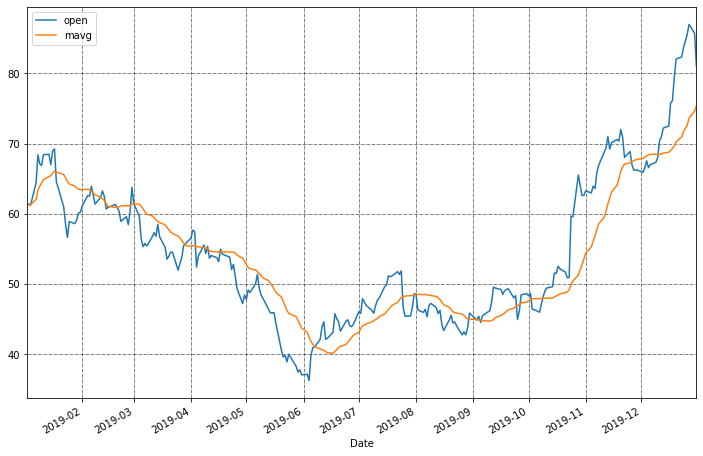

In [5]:
mavg20 = ta.volatility.bollinger_mavg(tsla['Open'], 20)

pd.DataFrame({
    'open': tsla['Open'],
    '20 day mavg': mavg20
}).plot(figsize=(12,8))

plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)

In [20]:
def delay_embed(data, norm, m, step = 1):
    """m is window length"""
    data = np.array(data)
    nt = data.shape[0] #length of original vector
    n = int((nt-m+1)/step) #number of lags
    traj_mat = np.empty((0,m)) #initialize delay embedded trajectory matrix
    for i in range(n):
        window_i = data[i*step:i*step + m]
        traj_mat = np.append(traj_mat, [window_i], axis=0 )
    
    if norm:
        traj_mat = (1/(nt**0.5)) * traj_mat #normalize by 1/sqrt(n)
    return traj_mat

def SSA(data, m, step, norm = True):
    """Performs SSA on time series with window size m and inter-window step size"""
    if type(data) != np.ndarray:
        data = np.array(data)
    nt = data.shape[0] #length of original vector
    n = int((nt-m+1)/step) #number of lags
    
    traj_mat = delay_embed(data, norm, m, step)
    pca = PCA(n_components = n)
    pca.fit(traj_mat.T)
    components = pca.components_
    e_spectrum = pca.explained_variance_ratio_
    
    return components, e_spectrum
    

In [30]:
data = np.array(tsla['Close'])

co, spec = SSA(data, m = 32, step =7)

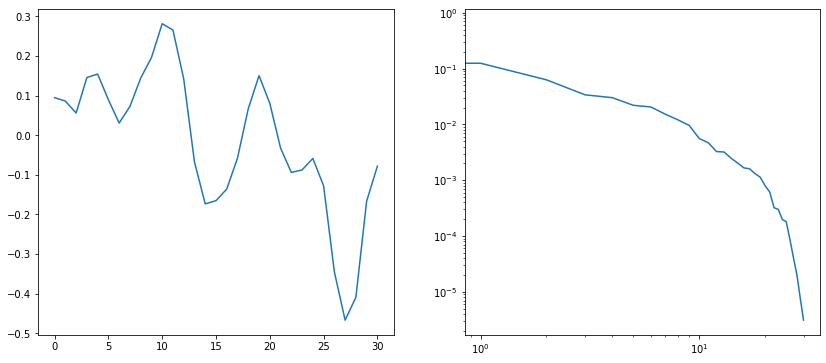

In [35]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(co[0])
plt.subplot(1,2,2)
plt.loglog(spec)

# DFA
from https://raphaelvallat.com/entropy/build/html/generated/entropy.detrended_fluctuation.html#entropy.detrended_fluctuation

In [42]:
def _linear_regression(x, y):
    """Fast linear regression using Numba.
    Parameters
    ----------
    x, y : ndarray, shape (n_times,)
        Variables
    Returns
    -------
    slope : float
        Slope of 1D least-square regression.
    intercept : float
        Intercept
    """
    n_times = x.size
    sx2 = 0
    sx = 0
    sy = 0
    sxy = 0
    for j in range(n_times):
        sx2 += x[j] ** 2
        sx += x[j]
        sxy += x[j] * y[j]
        sy += y[j]
    den = n_times * sx2 - (sx ** 2)
    num = n_times * sxy - sx * sy
    slope = num / den
    intercept = np.mean(y) - slope * np.mean(x)
    return slope, intercept

def _log_n(min_n, max_n, factor):
    """
    Creates a list of integer values by successively multiplying a minimum
    value min_n by a factor > 1 until a maximum value max_n is reached.
    Used for detrended fluctuation analysis (DFA).
    Function taken from the nolds python package
    (https://github.com/CSchoel/nolds) by Christopher Scholzel.
    Parameters
    ----------
    min_n (float):
        minimum value (must be < max_n)
    max_n (float):
        maximum value (must be > min_n)
    factor (float):
       factor used to increase min_n (must be > 1)
    Returns
    -------
    list of integers:
        min_n, min_n * factor, min_n * factor^2, ... min_n * factor^i < max_n
        without duplicates
    """
    max_i = int(floor(log(1.0 * max_n / min_n) / log(factor)))
    ns = [min_n]
    for i in range(max_i + 1):
        n = int(floor(min_n * (factor ** i)))
        if n > ns[-1]:
            ns.append(n)
    return np.array(ns, dtype=np.int64)

def dfa(x):
    """
    Utility function for detrended fluctuation analysis
    """
    N = len(x)
    nvals = _log_n(4, 0.1 * N, 1.2)
    walk = np.cumsum(x - x.mean())
    fluctuations = np.zeros(len(nvals))

    for i_n, n in enumerate(nvals):
        d = np.reshape(walk[:N - (N % n)], (N // n, n))
        ran_n = np.array([float(na) for na in range(n)])
        d_len = len(d)
        trend = np.empty((d_len, ran_n.size))
        for i in range(d_len):
            slope, intercept = _linear_regression(ran_n, d[i])
            trend[i, :] = intercept + slope * ran_n
        # Calculate root mean squares of walks in d around trend
        # Note that np.mean on specific axis is not supported by Numba
        flucs = np.sum((d - trend) ** 2, axis=1) / n
        # https://github.com/neuropsychology/NeuroKit/issues/206
        fluctuations[i_n] = np.sqrt(np.mean(flucs))

    # Filter zero
    nonzero = np.nonzero(fluctuations)[0]
    fluctuations = fluctuations[nonzero]
    nvals = nvals[nonzero]
    if len(fluctuations) == 0:
        # all fluctuations are zero => we cannot fit a line
        dfa = np.nan
    else:
        dfa, _ = _linear_regression(np.log(nvals), np.log(fluctuations))
    return dfa, fluctuations

Text(0.5, 1.0, 'Fluctuations')

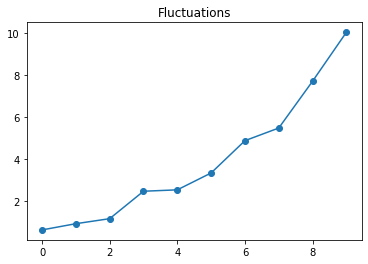

In [59]:
alpha, flux = dfa(data)
plt.plot(flux, 'o-')
plt.title('Fluctuations')

So we see some sort of nonlinearity as well as possibly different time scales.

Maybe DFA needs to be restricted to certain epochs (e.g. volatile vs bull vs bear).  How do we delineate between them? 

As a starting point, can separate epochs based on derivative of moving average.
- Based on the below plot, should create epochs > x% of the gradients are of a different sign than the last one (so that 1 different sign does not create a different epoch)
    - x = 10/252 = 4% based on the gradient plot below
- later can do when the derivative deviates a certain amount


Text(0.5, 1.0, 'Gradients for mavg20')

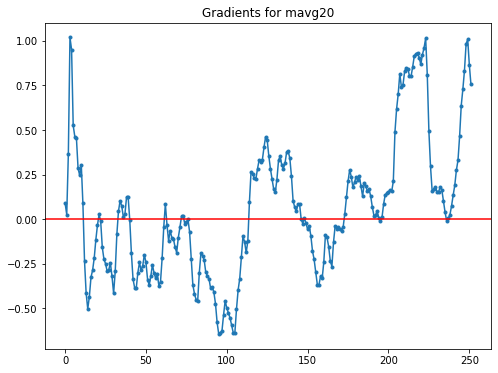

In [60]:
plt.figure(figsize=(8,6))
plt.plot(np.gradient(mavg20), '.-')
plt.axhline(y=0, color='r')
plt.title('Gradients for mavg20')

In [73]:
def create_epochs(data, mavg_len, min_pct = .05):
    """Separates time series into epochs based on moving average activity
    mavg is currently computed from ta library """
    mavg = ta.volatility.bollinger_mavg(data, mavg_len)
    min_epoch = int(min_pct*mavg.shape[0])
    gradients = np.gradient(mavg)
    epoch_indices = []

    sign_count = 0 #counts the consecutive number of a sign once the sign changes 
    encounter = 0
    for n_i, i in enumerate(gradients):     
        if n_i > 0:
            if past_sign != i**0:
                sign_count = 0
            else:
                sign_count +=1
                
        if sign_count >= min_epoch:
            epoch_indices.append(n_i)
        
        past_sign = i**0 #Sign to use in next iter; either -1 or 1
        
    return epoch_indices

This is broken for now

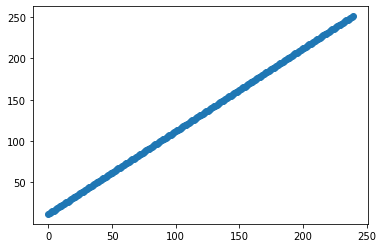

In [75]:
epoch_i = create_epochs(tsla['Open'], mavg_len = 20)
plt.plot(epoch_i, 'o')